## Garlic and Covid...
### DataPoint Armenia
#### **Disclaimer: there are assumptions in producing this code which have been made to produce this visualization. They are listed below.**

## Assumptions:
### **There is an assumption of linearity, we have decided to fit a linear model, but any other model might work**
### **The graph uses linear regression to come to a conclusion, but it doesn't meet the necessary LR requirements. For example we cannot say the deaths of the countries, or garlic production, are independently+normally distributed, which is a requirement for linear regression**
### **The garlic production data has a two year lag which causes a chronological error in the data, but this could be justified**
### **We cannot say that these two features are independantly distributed since countries which are closer to one another will have an effect on eachother in terms of both spread of corona virus and garlic production (sharing factors of soil quality, appropriate climate for garlic production, etc**
### **We are scaling the garlic production per sq mi of each country, which could be incorrect relative to the harvestable square mileage of garlic production per country**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from cycler import cycler
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy
from scipy.optimize import curve_fit

C:\Users\talin\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\talin\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\talin\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
area = pd.read_csv("countries of the world.csv")

In [3]:
#cleaning data
area['Region'] = [i.strip() for i in area['Region']]
area['Country'] = [i.strip() for i in area['Country']]

In [5]:
#selecting only middle eastern/near eastern regions
area = area[(area['Region'] == "C.W. OF IND. STATES") | (area['Region'] == 'EASTERN EUROPE') | (area['Region'] == 'NEAR EAST') | (area['Region'] == "ASIA (EX. NEAR EAST)")]

In [6]:
#garlic production dataset!
garlic = pd.read_csv("FAOSTAT_data_5-10-2020.csv")

In [60]:
#only keep official data rows (eradicates duplicates)
garlic = garlic[garlic['Flag Description'] == 'Official data']

In [9]:
#read rest of datasets
covid = pd.read_csv("COVID-19-master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
cases = pd.read_csv("COVID-19-master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [10]:
#function for covid data: 
def summing(df):
    df2 = pd.DataFrame(columns = df.columns)
    for i in df['Country/Region'].unique():
        df2 = df2.append(pd.DataFrame(df[df['Country/Region'] == i]).sum(), ignore_index = True)
    return df2         

In [11]:
cases = summing(cases)

In [12]:
covid = summing(covid)

In [16]:
countries = set(covid["Country/Region"]).intersection(set(garlic["Area"]))

In [17]:
countries = set(countries).intersection(set(area['Country']))

In [19]:
# get overlapping countries
covid = covid[covid['Country/Region'].isin(countries)]
cases = cases[cases['Country/Region'].isin(countries)]
garlic = garlic[garlic['Area'].isin(countries)]
area = area[area["Country"].isin(countries)]

In [22]:
# sort by country name so when doing row operations, everything is in correct order (makes it easier to divide/multiply dfs)
covid.sort_values("Country/Region", inplace = True)
cases.sort_values("Country/Region", inplace = True)
garlic.sort_values("Area", inplace = True)
area.sort_values("Country", inplace = True)

C:\Users\talin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [23]:
covid.reset_index(drop = True, inplace = True)
cases.reset_index(drop = True, inplace = True)
garlic.reset_index(drop = True, inplace = True)
area.reset_index(drop = True, inplace = True)

In [25]:
# here we are making a series of X_pop which consists of the deaths and cases per thousand population of each country 
deaths_pop = covid[covid.columns[-1]] / (area['Population'] / 10000) # smoke['pop2020']# / 100
cases_pop =  cases.iloc[:, -1] / (area['Population'] / 10000)# smoke['pop2020'] #/ 100

In [26]:
percent_death_to_cases = deaths_pop#/cases_pop

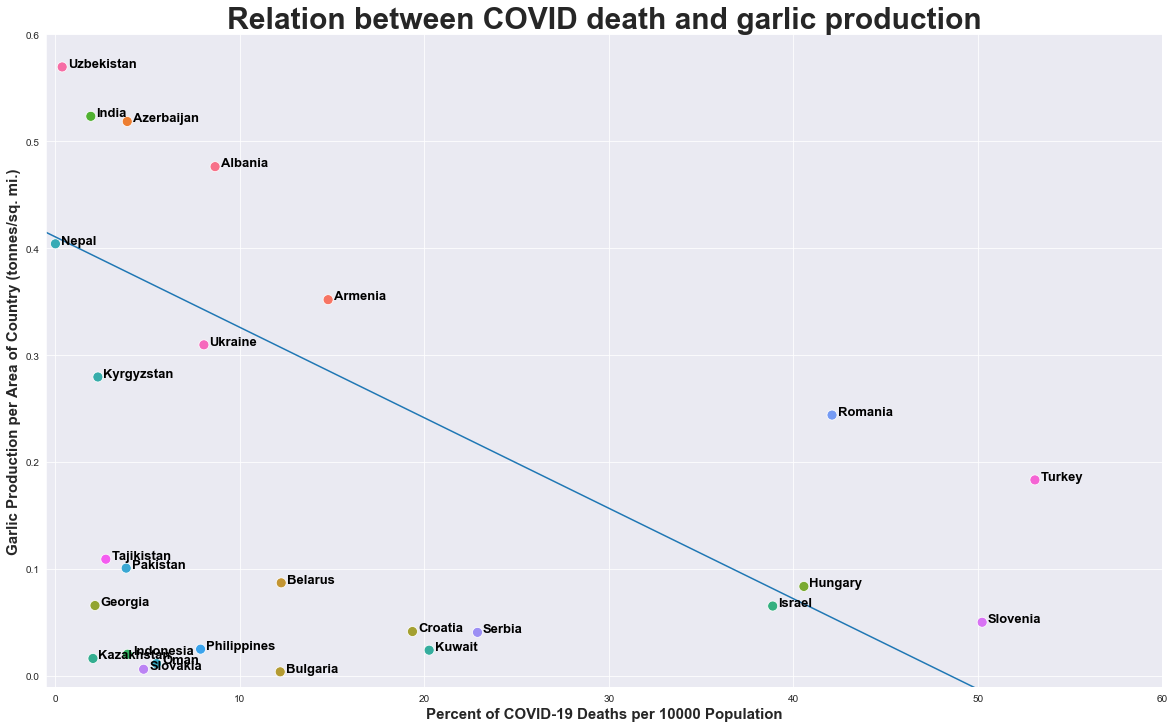

In [59]:
#plotting 
plt.figure(figsize=(20, 12))
sns.set_style("darkgrid")
x = percent_death_to_cases * 100
y = garlic['Value']/area['Area (sq. mi.)']
z = np.polyfit(x.astype(float).astype(float), y.astype(float), deg = 1)
p = np.poly1d(z)
xp = np.linspace(-.5, 80, 1000)
plt.plot(xp, p(xp), '-')
p1 = sns.scatterplot(x = x, y = y, hue = garlic['Area'], legend = False, s = 100)
sns.axes_style("darkgrid")
plt.xlim(-.5, 60)
plt.ylim(-.01, .6)
plt.xlabel("Percent of COVID-19 Deaths per 10000 Population", size = 'medium', weight = 'bold', fontsize= 15)
plt.ylabel("Garlic Production per Area of Country (tonnes/sq. mi.)", size = 'medium', weight = 'bold', fontsize= 15)
plt.title("Relation between COVID death and garlic production", size = 'large', weight = 'bold', fontsize= 30)


for line in range(0,garlic.shape[0]):
    if (percent_death_to_cases[line] * 100 +0.01 < 81) and (garlic['Value'][line]/area['Area (sq. mi.)'][line] < 1):
        p1.text(percent_death_to_cases[line] * 100 +0.3,garlic['Value'][line]/area['Area (sq. mi.)'][line], garlic['Area'][line], horizontalalignment='left', fontsize = 13, color='black', weight = 'semibold')

p1.figure.savefig('garlic.png')

In [31]:
np.corrcoef(x.astype(float),y.astype(float))

array([[ 1.        , -0.22537448],
       [-0.22537448,  1.        ]])

In [32]:
scipy.stats.pearsonr(x,y)

(-0.22537448353990583, 0.25835672180069147)